# Additional assignment. Kaggle dataset. House cost prediction

This dataset is taken to practice Week1 material on linear regression.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
from sklearn import datasets, linear_model, metrics
from sklearn import model_selection as mod_sel

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

sns.set()
sns.set_style("whitegrid")

%matplotlib inline

In [2]:
initial_train_data = pd.read_csv('data/10. train.csv')
initial_test_data = pd.read_csv('data/10. test.csv')

In [3]:
initial_train_data.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1322,1323,60,RL,107.0,10186,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
1081,1082,20,RL,75.0,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,133000
928,929,20,RL,NaN,11838,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,236500
142,143,50,RL,71.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,166000
1152,1153,20,RL,90.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Abnorml,230000


In [4]:
train_data = initial_train_data.loc[:, ['LotArea', 'SalePrice']]

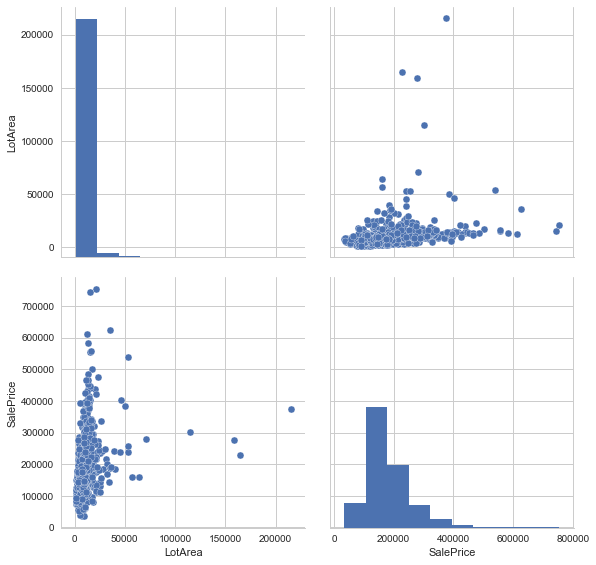

In [5]:
sns.pairplot(train_data, size=4.)